<a href="https://colab.research.google.com/github/artbogdanovai/fast_aicourse/blob/master/course/rice/gradient_accumulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trying to solve rice competiton
In pure pytorch instead of fast ai

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pynvml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import pathlib
import zipfile
import glob
#import fastai
from PIL import Image
import pandas as pd
#import timm
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [4]:
comp = 'paddy-disease-classification'


In [5]:
creds = '{"username":"artbogdanov","key":"c896dcbee655a8f2bf17e34fc875f65b"}'

In [6]:
if not os.path.exists(os.path.expanduser('~')+'/.kaggle'):
  os.makedirs(os.path.expanduser('~')+'/.kaggle')

In [7]:
with open(os.path.expanduser('~')+'/.kaggle/kaggle.json', 'w') as f:
    f.write(creds)

In [8]:
import kaggle

In [9]:
!ls 

paddy-disease-classification  paddy-disease-classification.zip	sample_data


In [10]:
path = pathlib.Path(comp)

In [11]:
if not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [12]:
example = glob.glob(str(path)+'/train_images/downy_mildew/*')[5]

In [13]:
im = Image.open(example)

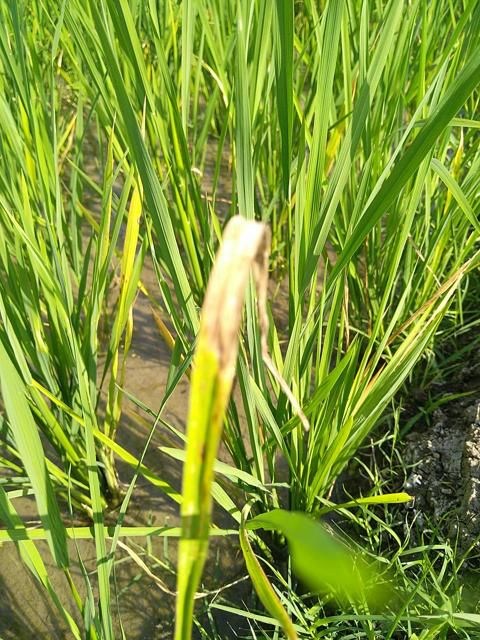

In [14]:
im

In [15]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
device

device(type='cuda', index=0)

In [16]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights


In [17]:
weights = EfficientNet_B3_Weights.DEFAULT
net = efficientnet_b3(weights=weights)
#EfficientNet_B3_Weights.IMAGENET1K_V1

In [18]:
preprocess = weights.transforms()

In [19]:
dataset = torchvision.datasets.ImageFolder(comp+'/train_images',preprocess)

In [20]:
dataset

Dataset ImageFolder
    Number of datapoints: 10407
    Root location: paddy-disease-classification/train_images
    StandardTransform
Transform: ImageClassification(
               crop_size=[300]
               resize_size=[320]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )

In [21]:
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(
    dataset, [train_size, valid_size], 
    generator=torch.Generator().manual_seed(42))

In [22]:
batch_size=32

In [23]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

In [24]:
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                          shuffle=True)

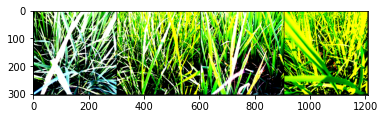

In [25]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
plt.imshow(np.transpose(torchvision.utils.make_grid(images[0:4]), (1, 2, 0)))
plt.show()

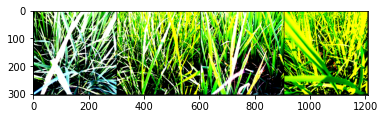

In [26]:
plt.imshow(np.transpose(torchvision.utils.make_grid(images[0:4]), (1, 2, 0)))
plt.show()


In [27]:
images[0].shape

torch.Size([3, 300, 300])

In [28]:
classes = dataset.classes
no_of_classes = len(classes)
classes

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [29]:
no_of_classes

10

In [30]:
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

brown_spot normal brown_spot normal


In [31]:
def calculate_test_accuracy(dataloader, save_results = False):
  global outtest
  total = 0
  correct = 0
  if save_results: res = pd.DataFrame()
  with torch.no_grad():
      for data in dataloader:
          images, labels = data[0].to(device), data[1].to(device)
          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          outtest = outputs
          if save_results: res = res.append(pd.DataFrame(outputs.cpu().numpy()))

  print(f'Accuracy of the network: {100 * correct // total} %')
  if save_results: return res

In [32]:
import torch.nn as nn
import torch.nn.functional as F




# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
#         self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
#         self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
#         self.fc = nn.Linear(32*15*15, 10)
        
#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.conv2(x))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.conv3(x))
#         x = F.max_pool2d(x, 2)
#         x = torch.flatten(x,1)
#         #print(x.shape)
#         x = self.fc(x)
#         return x

# net = Net()
# net = net.to(device)

In [33]:
#net = timm.create_model('resnet34', pretrained = True, num_classes=10)

In [34]:
net.fc = nn.Linear(in_features=3024, out_features=10, bias=True)

In [35]:
net = net.to(device)

In [36]:
images.shape

torch.Size([32, 3, 300, 300])

In [37]:
net.forward(images.to(device)).shape

torch.Size([32, 1000])

In [38]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [39]:
len(trainloader)

261

In [40]:
%%time
iter_count = 2
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    correct=0
    count=0
    for i, data in enumerate(trainloader):
        count+=1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)/iter_count
        loss.backward()
        if count % iter_count == 0:
            optimizer.step()
            optimizer.zero_grad()
        # print statistics
        with torch.no_grad():
            _, preds = torch.max(outputs.data, 1)
            
            correct += (preds == labels).float().sum()
            #print(preds,labels,(preds == labels).float().sum(),correct)
        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
    print(f'acc:{correct}, {len(trainloader)*batch_size}, {correct/(len(trainloader)*batch_size)}')
    calculate_test_accuracy(validloader)

print('Finished Training')

[1,   261] loss: 0.298
acc:1578.0, 8352, 0.1889367699623108
Accuracy of the network: 37 %
[2,   261] loss: 0.130
acc:3642.0, 8352, 0.4360632002353668
Accuracy of the network: 49 %
[3,   261] loss: 0.095
acc:4505.0, 8352, 0.5393917560577393
Accuracy of the network: 56 %
Finished Training
CPU times: user 11min 57s, sys: 2min 42s, total: 14min 40s
Wall time: 14min 53s


In [41]:
# [1,  1041] loss: 0.636
# acc:3215.0, 8328, 0.3860470652580261
# Accuracy of the network: 55 %
# Finished Training
# CPU times: user 4min 37s, sys: 24.7 s, total: 5min 2s
# Wall time: 5min 3s

# [1,  1041] loss: 0.993
# acc:3980.0, 8328, 0.47790583968162537
# Accuracy of the network: 67 %
# Finished Training
# CPU times: user 4min 38s, sys: 26.6 s, total: 5min 5s
# Wall time: 5min 6s

# [1,   521] loss: 0.627
# acc:3377.0, 8336, 0.40511035919189453
# Accuracy of the network: 58 %
# [2,   521] loss: 0.248
# acc:5771.0, 8336, 0.6922984719276428
# Accuracy of the network: 73 %
# [3,   521] loss: 0.153
# acc:6754.0, 8336, 0.8102207183837891
# Accuracy of the network: 80 %
# Finished Training
# CPU times: user 11min 41s, sys: 3min 15s, total: 14min 56s
# Wall time: 15min 5s

In [42]:
%%time
calculate_test_accuracy(trainloader)


Accuracy of the network: 60 %
CPU times: user 2min 22s, sys: 4.52 s, total: 2min 27s
Wall time: 2min 27s


In [43]:
%%time
calculate_test_accuracy(validloader)


Accuracy of the network: 56 %
CPU times: user 35.6 s, sys: 1.16 s, total: 36.7 s
Wall time: 36.8 s


In [44]:
torch.cuda.list_gpu_processes()

'GPU:0\nprocess      88649 uses    11589.000 MB GPU memory'

In [45]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [46]:
stop

NameError: ignored

In [ ]:
PATH = './torch_regnet.pth'
torch.save(net, PATH)

In [ ]:
model = net

In [ ]:
model.eval()

In [ ]:
calculate_test_accuracy(validloader,True).to_csv('torch_regnet_test.csv')

In [ ]:
all_images = glob.glob('paddy-disease-classification/test_images/*')

In [ ]:
results = pd.DataFrame(columns = ['image_id','label'])

In [ ]:
i=0
for im in all_images:
    name = im.split('/')[-1]
    image = Image.open(im).convert("RGB")
    image = preprocess(image).to(device)
    image = image.unsqueeze(0)
    with torch.no_grad():
        outputs = net(image)
    rice_class = dataset.classes[torch.max(outputs.data, 1)[1]]
    results.loc[len(results)] = [name,rice_class]
    i+=1
    if i%500 == 0:
      print(f'500 done {i}')

In [ ]:
results.to_csv('submission_regnet.csv',index=False)